In [225]:
import torch
# Check if GPU is available and set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Check GPU details
if device.type == 'cuda':
    print(f"Number of GPUs available: {torch.cuda.device_count()}")
    print(f"Current GPU device: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("No GPU available.")


Using device: cuda
Number of GPUs available: 2
Current GPU device: Tesla T4


In [2]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from transformers import AutoModel, AutoTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np



In [227]:
resume_data = pd.read_csv("/kaggle/input/resume-and-job-description/Resume.csv")
resume_data.head()

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [228]:
resume_data['Category'].value_counts()

Category
INFORMATION-TECHNOLOGY    120
BUSINESS-DEVELOPMENT      120
FINANCE                   118
ADVOCATE                  118
ACCOUNTANT                118
ENGINEERING               118
CHEF                      118
AVIATION                  117
FITNESS                   117
SALES                     116
BANKING                   115
HEALTHCARE                115
CONSULTANT                115
CONSTRUCTION              112
PUBLIC-RELATIONS          111
HR                        110
DESIGNER                  107
ARTS                      103
TEACHER                   102
APPAREL                    97
DIGITAL-MEDIA              96
AGRICULTURE                63
AUTOMOBILE                 36
BPO                        22
Name: count, dtype: int64

In [229]:
resume_data.shape


(2484, 4)

In [230]:
category_counts = resume_data['Category'].value_counts()
categories_to_keep = category_counts[category_counts >= 110].index
resume_data = resume_data[resume_data['Category'].isin(categories_to_keep)]


In [231]:
resume_data = resume_data.drop_duplicates()



In [232]:
resume_data.dropna(inplace=True)


In [233]:
resume_data.shape

(1858, 4)

In [234]:
job_description = pd.read_csv("/kaggle/input/resume-and-job-description/training_data.csv")
job_description.head()

,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."


In [235]:
job_description.shape

(853, 5)

In [236]:
job_description = job_description.drop_duplicates(subset='position_title').head(15)

In [237]:
job_description.shape

(15, 5)

## **Preprocessing text**

In [238]:
# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z]', ' ', text)
    sentences = sent_tokenize(text)
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))
    for sent in sentences:
        if any(criteria in sent for criteria in ['skills', 'education','experience']):
            words = word_tokenize(sent)
            words = [word for word in words if word not in stop_words]
            tagged_words = pos_tag(words)
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)
    return features

In [239]:
# Function to get embeddings from text
def get_embeddings(text, model_name):
    """Utility function to get BERT embeddings for a given text"""
    inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1).cpu().numpy()


In [240]:
# Function to print top matching resumes
def print_top_matching_resumes(result_group):
    for i in range(15):
        print("\nJob ID:", i)
        print("Cosine Similarity | Domain Resume | Domain Description")
        print(result_group.get_group(i)[['similarity', 'domainResume', 'domainDesc']])


In [241]:
# Process resume data
resume_data = resume_data.drop(["Resume_html"], axis=1)
resume_data['Feature'] = resume_data['Resume_str'].apply(lambda x: preprocess_text(x)['feature'])
resume_data = resume_data.drop(columns=['Resume_str'])
resume_data.to_csv("/kaggle/working/resume_data.csv", index=False)


In [242]:
df=pd.read_csv('/kaggle/working/resume_data.csv')
df.head()

,ID,Category,Feature
0,16852973,HR,hr administrator marketing associate hr admini...
1,22323967,HR,hr specialist hr operations summary media prof...
2,33176873,HR,hr director summary years experience recruitin...
3,27018550,HR,hr specialist summary dedicated driven dynamic...
4,17812897,HR,hr manager skill highlights hr skills hr depar...


In [243]:
job_description = job_description[["job_description", "position_title"]]
job_description['Features'] = job_description['job_description'].apply(lambda x: preprocess_text(x)['feature'])
job_description = job_description.drop(columns=['job_description'])
job_description.to_csv("/kaggle/working/job_data1.csv", index=False)


In [244]:
ds=pd.read_csv('/kaggle/working/job_data1.csv')
ds.head()

,position_title,Features
0,Sales Specialist,minimum qualifications bachelors degree equiva...
1,Apple Solutions Consultant,description asc highly influential growing min...
2,Licensing Coordinator - Consumer Products,amazing time joining netflix continue transfor...
3,Web Designer,description web designers looking expand profe...
4,Web Developer,trackfive weve got big goals mission revolutio...


In [246]:
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.metrics.pairwise import cosine_similarity

# Define threshold for qualification
QUALIFICATION_THRESHOLD = 0.75

def main():
    global device, model, tokenizer

    # Initialize model and tokenizer
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model_name = "bert-base-uncased"
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(model_name)
    model.to(device)

    # Get embeddings for job descriptions and resumes
    job_desc_embeddings = np.array([get_embeddings(desc, model_name) for desc in job_description['Features']]).squeeze()
    resume_embeddings = np.array([get_embeddings(text, model_name) for text in resume_data['Feature']]).squeeze()

    # Compute similarity and build results dataframe
    result_list = []
    for i, job_desc_emb in enumerate(job_desc_embeddings):
        similarities = cosine_similarity([job_desc_emb], resume_embeddings)
        top_k_indices = np.argsort(similarities[0])[::-1]
        
        # Collect candidates and determine qualification
        for j in top_k_indices:
            similarity_score = similarities[0][j]
            qualifies = similarity_score >= QUALIFICATION_THRESHOLD

            result_list.append({
                'jobId': i,
                'resumeId': resume_data['ID'].iloc[j],
                'similarity': similarity_score,
                'domainResume': resume_data['Category'].iloc[j],
                'domainDesc': job_description['position_title'].iloc[i],
                'qualifies': qualifies
            })

    # Create result DataFrame and separate into qualified and non-qualified candidates
    result_df = pd.DataFrame(result_list)

    # Filter qualified and non-qualified candidates
    qualified_df = result_df[result_df['qualifies']]
    non_qualified_df = result_df[~result_df['qualifies']]

    # Balance the results: Ensure 50% qualified and 50% non-qualified
    num_qualified = min(len(qualified_df), len(non_qualified_df))
    balanced_df = pd.concat([qualified_df.head(num_qualified), non_qualified_df.head(num_qualified)])

    # Ensure the CSV output includes 2484 rows
    if len(balanced_df) < 2484:
        balanced_df = pd.concat([balanced_df] * (2484 // len(balanced_df) + 1), ignore_index=True).head(2484)
    
    # Add text back to results and save CSV
    balanced_df['resumeText'] = balanced_df['resumeId'].apply(
        lambda x: resume_data.loc[resume_data['ID'] == x, 'Feature'].values[0] 
        if len(resume_data.loc[resume_data['ID'] == x, 'Feature']) > 0 else ''
    )
    
    # Using `iloc` with an additional check to ensure index exists
    balanced_df['jobDescription'] = balanced_df['jobId'].apply(
        lambda x: job_description['Features'].iloc[x] if x < len(job_description) else ''
    )

    final_result_df = balanced_df[['resumeText', 'jobDescription', 'similarity', 'domainResume', 'domainDesc']]

    # Save the final balanced results to CSV
    final_result_df.to_csv("/kaggle/working/matched_results2.csv", index=False)

if __name__ == "__main__":
    main()


## **Final Dataset: EDA**

In [263]:
df=pd.read_csv('/kaggle/working/matched_results2.csv')
df.head()

,resumeText,jobDescription,similarity,domainResume,domainDesc
0,business development specialist professional o...,minimum qualifications bachelors degree equiva...,0.937873,BUSINESS-DEVELOPMENT,Sales Specialist
1,vice president information technology software...,minimum qualifications bachelors degree equiva...,0.930880,INFORMATION-TECHNOLOGY,Sales Specialist
2,business development manager professional summ...,minimum qualifications bachelors degree equiva...,0.929713,BUSINESS-DEVELOPMENT,Sales Specialist
3,z sales consultant summary highly motivated co...,minimum qualifications bachelors degree equiva...,0.929638,SALES,Sales Specialist
4,consultant summary proud microsoft employee dr...,minimum qualifications bachelors degree equiva...,0.929602,CONSULTANT,Sales Specialist


In [264]:
df.dropna(inplace=True)

In [ ]:
df = df.drop_duplicates()


In [265]:
df.shape

(7783, 5)

In [267]:
#check similarity score less than 0.75
num_less_than_075 = len(df[df['similarity'] < 0.75])

num_less_than_075

3881

In [268]:
#craeting class column
df['class'] = df['similarity'].apply(lambda x: 'qualify' if x >= 0.75 else 'not_qualify')
df = df.drop(columns=['domainResume', 'domainDesc'])

In [269]:
df.head()

,resumeText,jobDescription,similarity,class
0,business development specialist professional o...,minimum qualifications bachelors degree equiva...,0.937873,qualify
1,vice president information technology software...,minimum qualifications bachelors degree equiva...,0.930880,qualify
2,business development manager professional summ...,minimum qualifications bachelors degree equiva...,0.929713,qualify
3,z sales consultant summary highly motivated co...,minimum qualifications bachelors degree equiva...,0.929638,qualify
4,consultant summary proud microsoft employee dr...,minimum qualifications bachelors degree equiva...,0.929602,qualify


In [274]:
df['class'].value_counts()

class
qualify        3894
not_qualify    3881
Name: count, dtype: int64

In [ ]:
df.to_csv('/kaggle/working/merged_data.csv', index=False)

## **Data Visualization**

In [ ]:
df=pd.read_csv('/kaggle/input/final-dataset/merged_data.csv')

In [4]:
#important libraries for visualisation
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")
plt.style.use('seaborn-dark-palette')



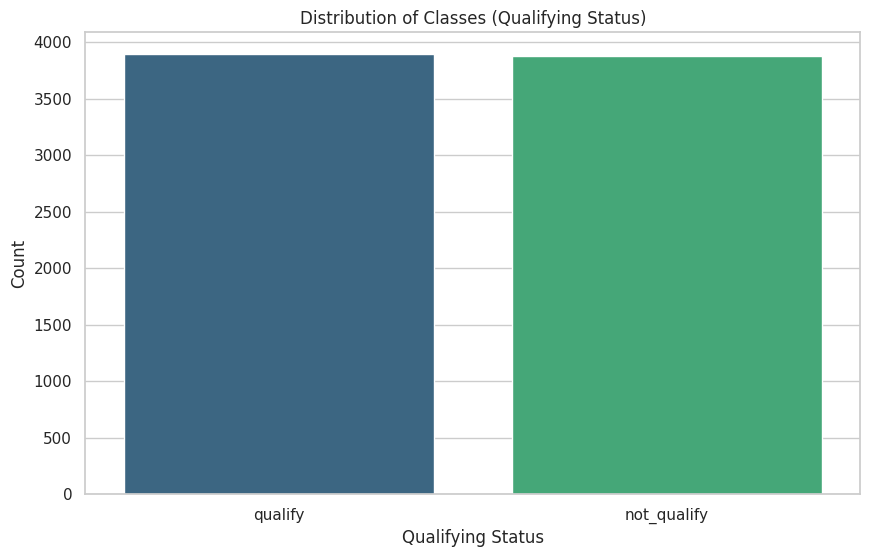

In [5]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='class', order=df['class'].value_counts().index, palette='viridis')
plt.title('Distribution of Classes (Qualifying Status)')
plt.xlabel('Qualifying Status')
plt.ylabel('Count')
plt.xticks(rotation=0)  # No rotation needed for class labels
plt.show()

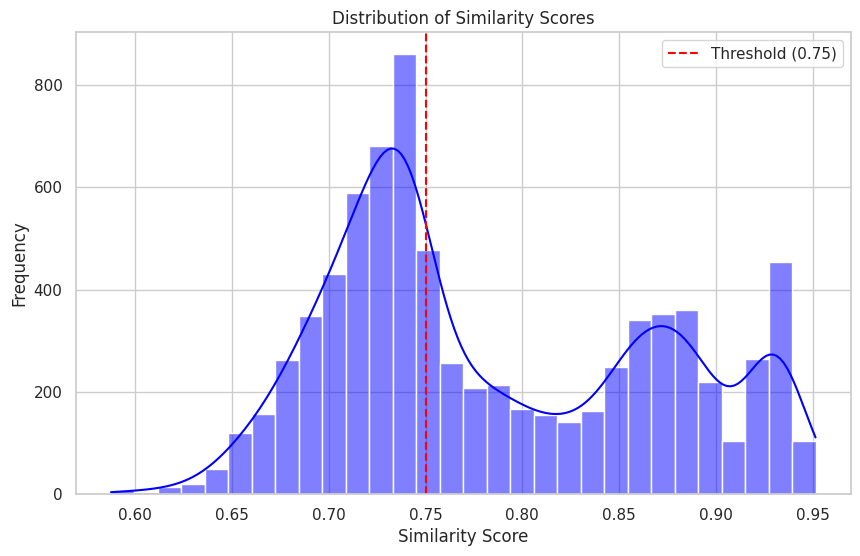

In [278]:
plt.figure(figsize=(10, 6))
sns.histplot(df['similarity'], bins=30, kde=True, color='blue')
plt.title('Distribution of Similarity Scores')
plt.xlabel('Similarity Score')
plt.ylabel('Frequency')
plt.axvline(x=0.75, color='red', linestyle='--', label='Threshold (0.75)')
plt.legend()
plt.show()

In [42]:
skills = [
    'Java', 'J2EE', 'Spring', 'Hibernate', 'Microservices', 'APIs', 'SQL', 'JavaScript',  # Java Developer
    'Manual Testing', 'Automation Testing', 'Selenium', 'JUnit', 'TestNG', 'Bug Tracking',  # Testing
    'CI/CD', 'Docker', 'Kubernetes', 'Jenkins', 'AWS', 'Azure', 'Python', 'Linux',  # DevOps Engineer
    'Python', 'Flask', 'Django', 'Pandas', 'Numpy', 'APIs', 'Databases', 'Machine Learning',  # Python Developer
    'HTML', 'CSS', 'JavaScript', 'UX/UI Design', 'Adobe Creative Suite', 'Responsive Design',  # Web Designing
    'Payroll systems', 'HRIS', 'Recruitment strategies', 'Employee engagement',  # HR
    'Hadoop', 'MapReduce', 'HDFS', 'HBase', 'Hive', 'Pig', 'Spark',  # Hadoop
    'CRM software', 'Sales strategies', 'Data analysis',  # Sales
    'Python', 'R', 'SQL', 'Machine Learning', 'Deep Learning', 'Data visualization', 'Statistics',  # Data Science
    'CAD', 'SolidWorks', 'FEA', 'Thermodynamics', 'Manufacturing processes',  # Mechanical Engineer
    'ETL tools', 'SQL', 'Data Warehousing', 'Data pipelines',  # ETL Developer
    'Blockchain technology', 'Smart Contracts', 'Solidity', 'Cryptography', 'Ethereum', 'Hyperledger',  # Blockchain
    'Project management', 'ERP systems', 'Supply chain management', 'Lean Six Sigma',  # Operations Manager
    'Adobe Creative Suite', 'Painting', 'Drawing', 'Photography', 'Sculpture',  # Arts
    'SQL', 'NoSQL', 'Database design', 'Database management', 'Data analysis',  # Database
    'Health and fitness programs', 'Nutrition', 'Exercise science', 'Personal training',  # Health and Fitness
    'Project Management', 'Agile', 'Risk Management', 'Resource Allocation',  # PMO
    'Electrical circuits', 'Power systems', 'Electronics', 'Control systems',  # Electrical Engineering
    'Business analysis', 'Requirements gathering', 'Process improvement', 'Data analysis',  # Business Analyst
    'C#', 'ASP.NET', 'MVC', 'Entity Framework', 'SQL', 'Web development',  # DotNet Developer
    'Automation Testing', 'Selenium', 'TestNG', 'Continuous Integration', 'Jenkins',  # Automation Testing
    'Network Security', 'Firewalls', 'Intrusion Detection', 'Ethical Hacking', 'VPNs',  # Network Security Engineer
    'Civil engineering', 'Structural analysis', 'Construction management', 'Geotechnical engineering',  # Civil Engineer
    'SAP modules', 'ERP', 'Business process integration', 'SAP HANA',  # SAP Developer
    'Legal research', 'Client consultation', 'Court procedures', 'Legal documentation',  # Advocate
    'Information Technology', 'IT strategy', 'System integration', 'Project management',  # Information Technology
    'Business development', 'Market analysis', 'Sales strategies', 'Client acquisition',  # Business Development
    'Culinary arts', 'Food safety', 'Menu creation', 'Restaurant management',  # Chef
    'Engineering principles', 'Design and development', 'Project management', 'Technical expertise',  # Engineering
    'Accounting principles', 'Financial reporting', 'Taxation', 'Auditing',  # Accountant
    'Finance management', 'Investment analysis', 'Risk management', 'Financial planning',  # Finance
    'Fitness training', 'Nutrition planning', 'Exercise techniques', 'Personal coaching',  # Fitness
    'Aviation technology', 'Flight operations', 'Aircraft maintenance', 'Air traffic control',  # Aviation
    'Sales strategies', 'Customer relationship management', 'Market analysis', 'Negotiation',  # Sales
    'Banking operations', 'Financial services', 'Customer service', 'Risk assessment',  # Banking
    'Healthcare services', 'Patient care', 'Medical procedures', 'Healthcare management',  # Healthcare
    'Consulting', 'Client management', 'Business strategy', 'Problem-solving',  # Consultant
    'Construction management', 'Project planning', 'Site management', 'Building codes',  # Construction
    'Public relations', 'Media relations', 'Crisis management', 'Communication',  # Public Relations
    'Design principles', 'Creativity', 'Graphic design', 'Adobe Creative Suite',  # Designer
    'Teaching methods', 'Lesson planning', 'Student engagement', 'Curriculum development',  # Teacher
    'Fashion design', 'Trend analysis', 'Textile knowledge', 'Product development',  # Apparel
    'Digital marketing', 'SEO', 'Content creation', 'Social media management',  # Digital Media
    'Agricultural technology', 'Crop management', 'Soil science', 'Farm management',  # Agriculture
    'Automotive technology', 'Vehicle maintenance', 'Engine repair', 'Automobile systems',  # Automobile
    'BPO operations', 'Customer service', 'Process management', 'Quality assurance'  # BPO
]


In [43]:
# Convert the list to a set for efficient membership testing
skills_set = set(skill.lower() for skill in skills)

def extract_skills(resume_text):
    resume_text = resume_text.lower()
    matched_skills = [skill for skill in skills_set if skill in resume_text]
    return ', '.join(matched_skills)

df['SkillR'] = df['resumeText'].apply(extract_skills)


In [44]:
# Convert the list to a set for efficient membership testing
skills_set = set(skill.lower() for skill in skills)

def extract_skills(resume_text):
    resume_text = resume_text.lower()
    matched_skills = [skill for skill in skills_set if skill in resume_text]
    return ', '.join(matched_skills)

df['SkillJD'] = df['jobDescription'].apply(extract_skills)


In [45]:
df.head()

,resumeText,jobDescription,similarity,class,SkillR,SkillJD
0,business development specialist professional o...,minimum qualifications bachelors degree equiva...,0.937873,qualify,"communication, r, network security, erp, busin...","communication, r, business strategy, erp"
1,vice president information technology software...,minimum qualifications bachelors degree equiva...,0.930880,qualify,"communication, r, agile, information technolog...","communication, r, business strategy, erp"
2,business development manager professional summ...,minimum qualifications bachelors degree equiva...,0.929713,qualify,"communication, r, erp systems, negotiation, pr...","communication, r, business strategy, erp"
3,z sales consultant summary highly motivated co...,minimum qualifications bachelors degree equiva...,0.929638,qualify,"r, fea","communication, r, business strategy, erp"
4,consultant summary proud microsoft employee dr...,minimum qualifications bachelors degree equiva...,0.929602,qualify,"communication, r, risk assessment, erp","communication, r, business strategy, erp"


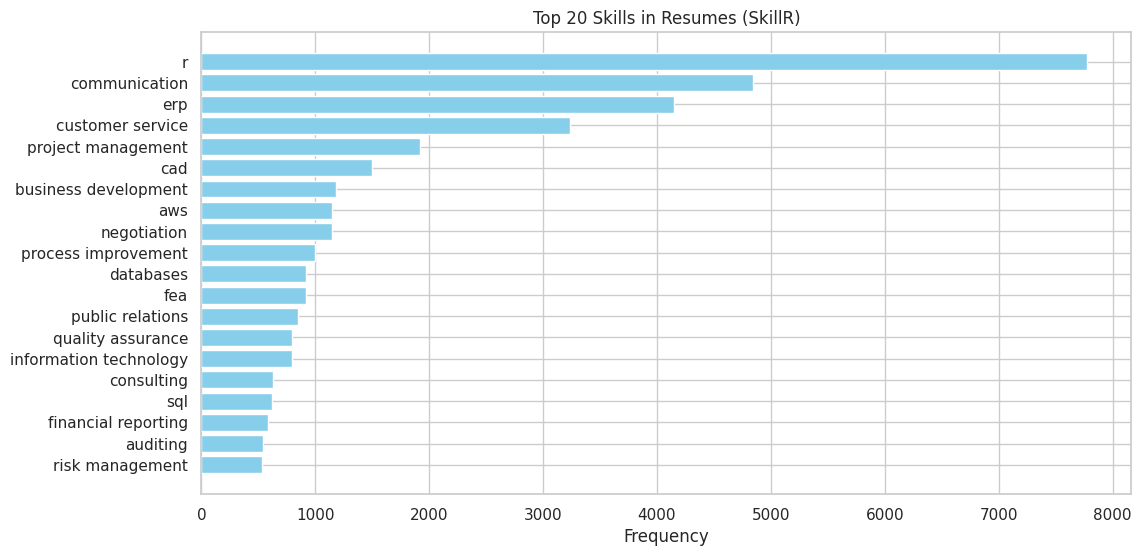

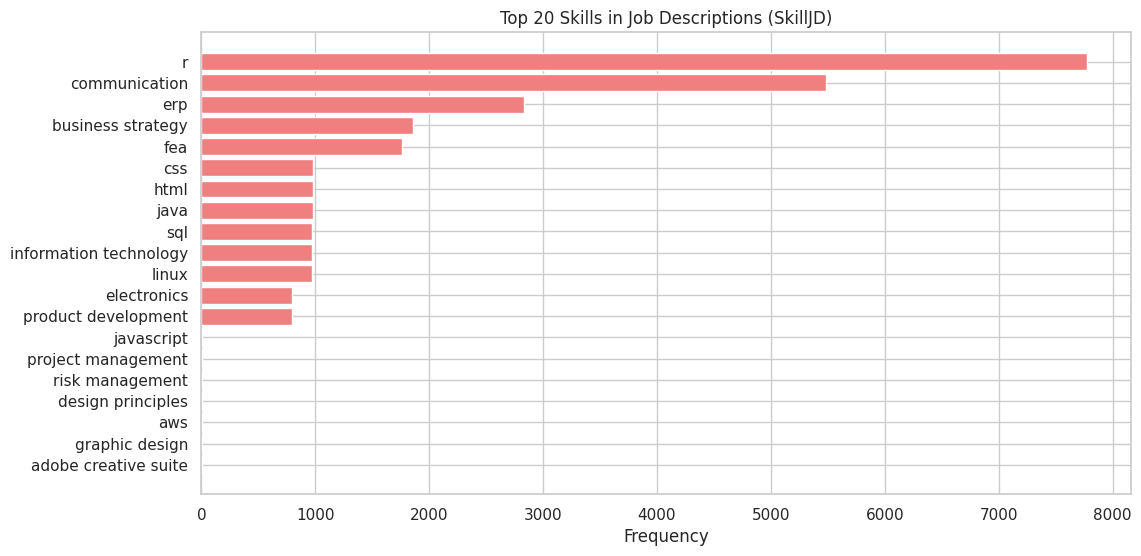

In [47]:
from collections import Counter

# Count the frequency of each skill in SkillR and SkillJD separately
all_resume_skills = ', '.join([skills for skills in df['SkillR'].dropna()])
all_jd_skills = ', '.join([skills for skills in df['SkillJD'].dropna()])

# Create skill lists
resume_skill_list = all_resume_skills.split(', ')
jd_skill_list = all_jd_skills.split(', ')

# Count frequency of skills
resume_skill_counts = Counter(resume_skill_list)
jd_skill_counts = Counter(jd_skill_list)

# Get the top 20 skills for each
top_resume_skills = resume_skill_counts.most_common(20)
top_jd_skills = jd_skill_counts.most_common(20)

# Plot function for top skills
def plot_top_skills(skill_counts, title, color):
    skills, counts = zip(*skill_counts)
    plt.figure(figsize=(12, 6))
    plt.barh(skills, counts, color=color)
    plt.xlabel('Frequency')
    plt.title(title)
    plt.gca().invert_yaxis()  # Invert y-axis for readability
    plt.show()

    # Plot top 20 skills 
plot_top_skills(top_resume_skills, 'Top 20 Skills in Resumes (SkillR)', 'skyblue')
plot_top_skills(top_jd_skills, 'Top 20 Skills in Job Descriptions (SkillJD)', 'lightcoral')


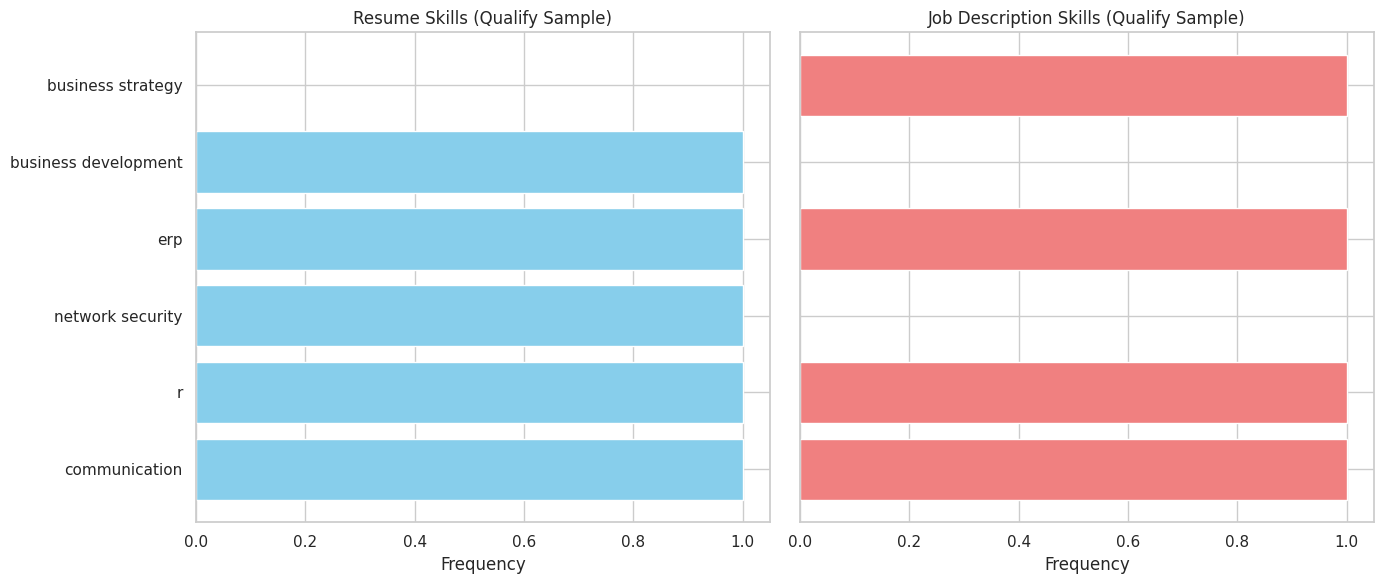

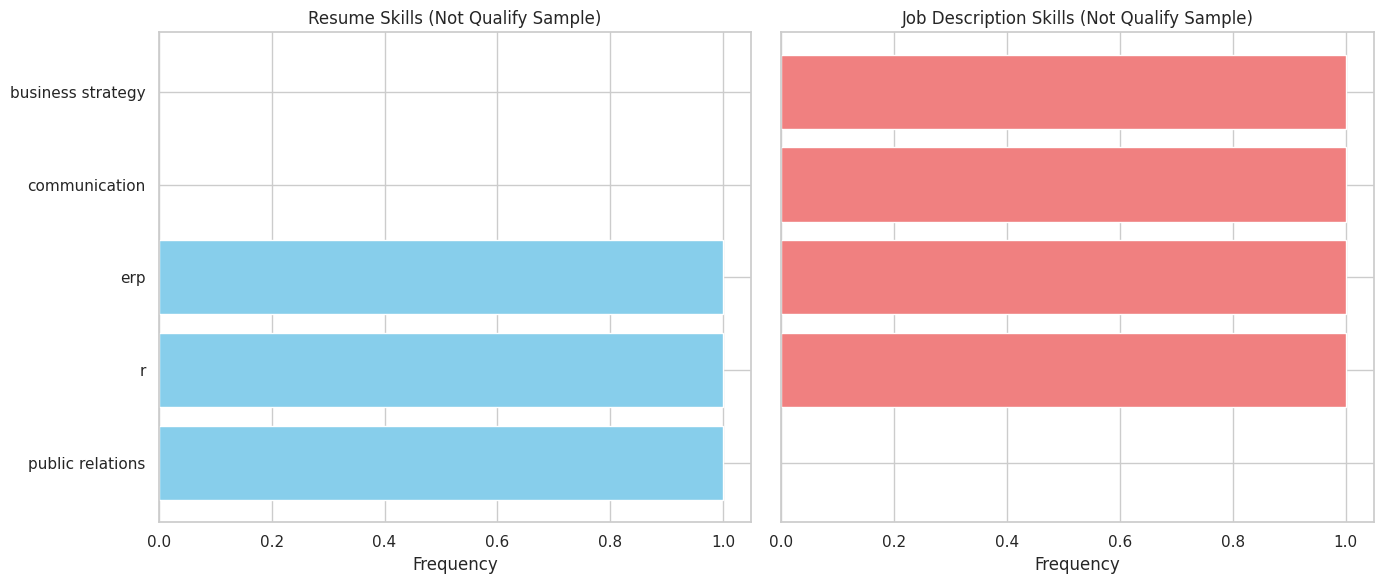

In [48]:
qualify_sample = df[df['class'] == 'qualify'].iloc[0]  # Get the first instance with class 'qualify'
not_qualify_sample = df[df['class'] == 'not_qualify'].iloc[0]  # Get the first instance with class 'not_qualify'

# function to plot skills for a given resume and job description
def plot_skills(resume_skills, jd_skills, title_resume, title_jd):
    # Split the skills into lists
    resume_skill_list = resume_skills.split(', ')
    jd_skill_list = jd_skills.split(', ')

    # Count frequency of skills
    resume_skill_counts = Counter(resume_skill_list)
    jd_skill_counts = Counter(jd_skill_list)

    # Create plots for resume skills and job description skills
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

    # Resume Skills Plot
    axes[0].barh(list(resume_skill_counts.keys()), list(resume_skill_counts.values()), color='skyblue')
    axes[0].set_title(title_resume)
    axes[0].set_xlabel('Frequency')
    axes[0].invert_yaxis()

    # Job Description Skills Plot
    axes[1].barh(list(jd_skill_counts.keys()), list(jd_skill_counts.values()), color='lightcoral')
    axes[1].set_title(title_jd)
    axes[1].set_xlabel('Frequency')
    axes[1].invert_yaxis()

    plt.tight_layout()
    plt.show()

# Plot skills for a sample with class 'qualify' and 'not_qualify'
plot_skills(
    qualify_sample['SkillR'],
    qualify_sample['SkillJD'],
    title_resume='Resume Skills (Qualify Sample)',
    title_jd='Job Description Skills (Qualify Sample)'
)

plot_skills(
    not_qualify_sample['SkillR'],
    not_qualify_sample['SkillJD'],
    title_resume='Resume Skills (Not Qualify Sample)',
    title_jd='Job Description Skills (Not Qualify Sample)'
)


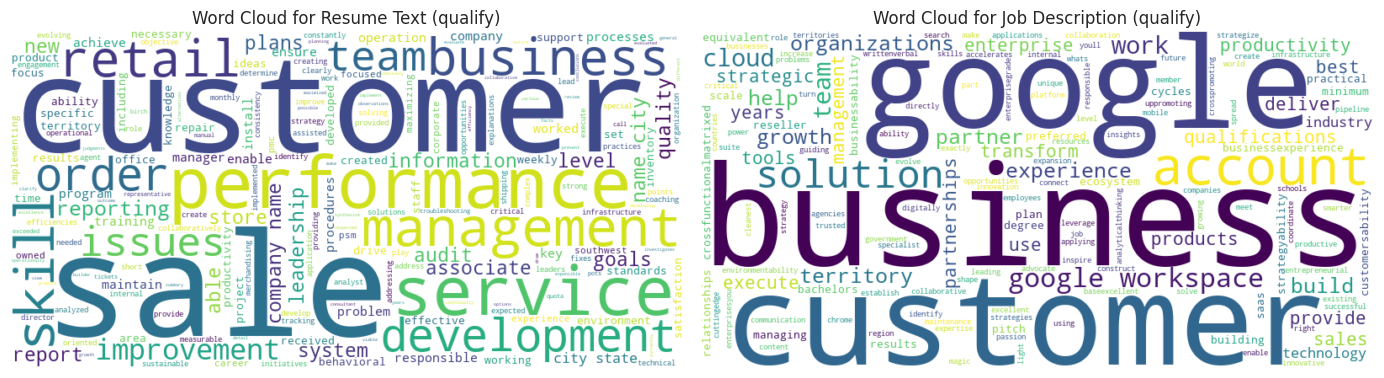

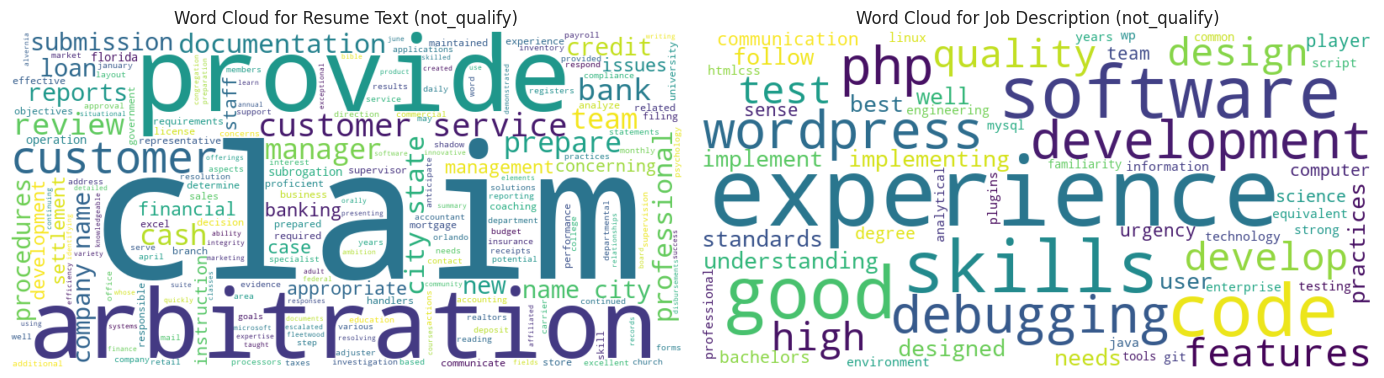

In [70]:
from wordcloud import WordCloud

# Function to generate and display word clouds
def generate_word_clouds(resume_text, job_description, title_suffix):
    plt.figure(figsize=(14, 6))
    # Word Cloud for resumeText
    plt.subplot(1, 2, 1)
    resume_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(resume_text)
    plt.imshow(resume_wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.title(f'Word Cloud for Resume Text {title_suffix}')

    # Word Cloud for jobDescription
    plt.subplot(1, 2, 2)
    job_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(job_description)
    plt.imshow(job_wordcloud, interpolation='bilinear')
    plt.axis('off')  # Hide axes
    plt.title(f'Word Cloud for Job Description {title_suffix}')
    plt.tight_layout()
    plt.show()


# Filter the DataFrame into matched and unmatched resumes based on similarity
matched_df = df[df['similarity'] >= 0.75]
unmatched_df = df[df['similarity'] < 0.75]

# Randomly select 1 matched and 1 unmatched indices
matched_indices = random.sample(range(len(matched_df)), min(1, len(matched_df)))
unmatched_indices = random.sample(range(len(unmatched_df)), min(1, len(unmatched_df)))


# Plot matched resumes
for index in matched_indices:
    resume_text = matched_df['resumeText'].iloc[index]  # Get resume text
    job_description = matched_df['jobDescription'].iloc[index]  # Get job description
    generate_word_clouds(resume_text, job_description, title_suffix='(qualify)')

# Plot unmatched resumes
for index in unmatched_indices:
    resume_text = unmatched_df['resumeText'].iloc[index]  # Get resume text
    job_description = unmatched_df['jobDescription'].iloc[index]  # Get job description
    generate_word_clouds(resume_text, job_description, title_suffix='(not_qualify)')


## **Data Preprocesing**

In [280]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

In [281]:
# Download stopwords
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [282]:
from transformers import BertTokenizer, BertModel
import time
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [283]:
# Load BERT Model and Tokenizer
start_time = time.time()  

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased').to(device)
model.eval()

end_time = time.time()  
print(f"Cell 2 executed in {end_time - start_time:.2f} seconds.")


Cell 2 executed in 1.54 seconds.


In [284]:
# Define Function to Get BERT Embeddings with Batch Processing
def get_bert_embeddings_batch(texts, batch_size=16):
    embeddings = []
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i + batch_size]
        inputs = tokenizer(batch_texts, return_tensors='pt', truncation=True, padding=True, max_length=512)
        inputs = {key: value.to(device) for key, value in inputs.items()}  
        
        with torch.no_grad():
            outputs = model(**inputs)
        
        batch_embeddings = outputs.last_hidden_state.mean(dim=1).cpu().numpy()  
        embeddings.append(batch_embeddings)  

    return np.vstack(embeddings) 


In [285]:
# Get BERT Embeddings for Resume Texts
start_time = time.time() 

df['resume_embedding'] = list(get_bert_embeddings_batch(df['resumeText'].tolist()))
end_time = time.time()  # End timing
print(f"Cell 4 executed in {end_time - start_time:.2f} seconds.")


Cell 4 executed in 514.08 seconds.


In [286]:
# Get BERT Embeddings for Job Descriptions
start_time = time.time()  

df['job_desc_embedding'] = list(get_bert_embeddings_batch(df['jobDescription'].tolist()))
end_time = time.time()  
print(f"Cell 5 executed in {end_time - start_time:.2f} seconds.")


Cell 5 executed in 128.70 seconds.


In [287]:
# Stack Embeddings into a Usable Format
start_time = time.time() 
resume_embeddings = np.vstack(df['resume_embedding'])
job_desc_embeddings = np.vstack(df['job_desc_embedding'])


X = np.hstack((resume_embeddings, job_desc_embeddings))
y = df['class']

end_time = time.time()  
print(f"Cell 6 executed in {end_time - start_time:.2f} seconds.")


Cell 6 executed in 0.07 seconds.


In [288]:
X_df = pd.DataFrame(X)
X_df['class'] = y.values
output_file = '/kaggle/working/final_df.csv'
X_df.to_csv(output_file, index=False)


In [289]:

df=pd.read_csv('/kaggle/working/final_df.csv')
df.head()


,0,1,2,3,4,5,6,7,8,9,...,1527,1528,1529,1530,1531,1532,1533,1534,1535,class
0,-0.085863,0.319668,0.528659,-0.112753,0.330351,0.066271,0.201286,0.049429,-0.080895,-0.188014,...,-0.389533,0.292297,-0.049649,0.194263,-0.131796,-0.292726,-0.548869,-0.079519,-0.099603,qualify
1,-0.052876,0.264776,0.865447,-0.203301,0.543044,0.145524,0.264235,-0.036763,-0.143509,-0.345316,...,-0.389533,0.292297,-0.049649,0.194263,-0.131796,-0.292726,-0.548869,-0.079519,-0.099603,qualify
2,-0.273835,0.328383,0.583195,-0.280860,0.458367,0.096446,0.143140,-0.019413,-0.230648,-0.193514,...,-0.389533,0.292297,-0.049649,0.194263,-0.131796,-0.292726,-0.548869,-0.079519,-0.099603,qualify
3,-0.012510,0.349865,0.459831,-0.105526,0.379396,0.124383,0.137215,0.055501,-0.056086,-0.211750,...,-0.389533,0.292297,-0.049649,0.194263,-0.131796,-0.292726,-0.548869,-0.079519,-0.099603,qualify
4,-0.198645,0.194215,0.635574,-0.164548,0.510161,0.103390,0.272512,-0.053970,-0.183534,-0.265075,...,-0.389533,0.292297,-0.049649,0.194263,-0.131796,-0.292726,-0.548869,-0.079519,-0.099603,qualify


In [290]:
df['class'] = df['class'].replace({'qualify': 1, 'not_qualify': 0})

In [291]:
y = df['class']
X = df.drop(columns=['class'])

## **Model Building**

In [302]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [293]:
# Split the data into train, validation, and test sets with stratification
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)  # 80% training, 20% temp
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)  # 10% validation, 10% test


## **Random Forest**


In [294]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)



RandomForestClassifier(random_state=42)

In [295]:
#Calculate Training Accuracy
y_train_pred = rf_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)

In [296]:
# Calculate Test Accuracy
y_test_pred = rf_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)

In [298]:
# Calculate Bias and Variance
bias_squared = np.mean((y_train - y_train_pred) ** 2)
variance = np.mean((y_test_pred - np.mean(y_test_pred)) ** 2)

In [299]:
#Display results
print(f"Training Accuracy: {train_accuracy:.2f}")
print(f"Test Accuracy: {test_accuracy:.2f}")
print(f"bias_squared: {bias_squared:.2f}")
print(f"Variance: {variance:.2f}")


Training Accuracy: 1.00
Test Accuracy: 0.98
bias_squared: 0.00
Variance: 0.25


              precision    recall  f1-score   support

           0       0.99      0.97      0.98       388
           1       0.97      0.99      0.98       390

    accuracy                           0.98       778
   macro avg       0.98      0.98      0.98       778
weighted avg       0.98      0.98      0.98       778



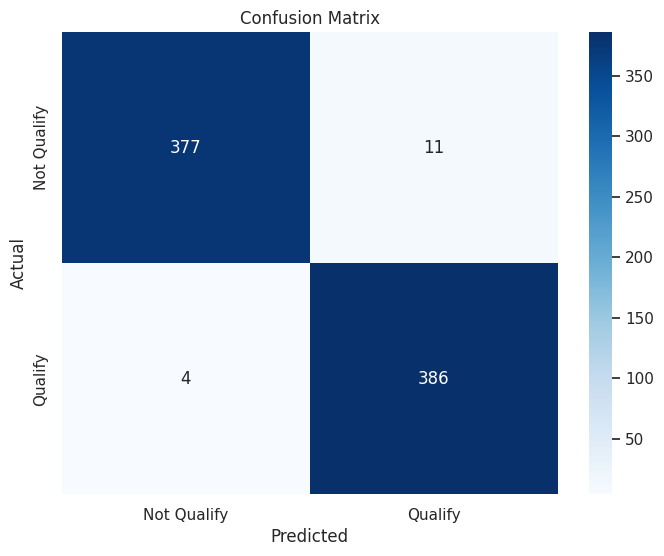

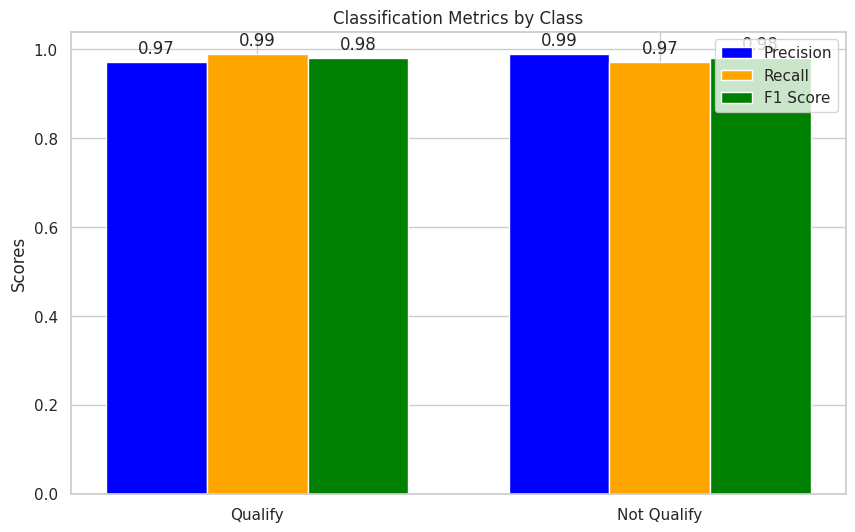

In [304]:
from sklearn.metrics import classification_report, confusion_matrix
y_test_pred = rf_model.predict(X_test)
report = classification_report(y_test, y_test_pred, output_dict=True)
print(classification_report(y_test, y_test_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Qualify', 'Qualify'], yticklabels=['Not Qualify', 'Qualify'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Extract metrics for precision, recall, and F1-score
precision = [report['1']['precision'], report['0']['precision']]
recall = [report['1']['recall'], report['0']['recall']]
f1_score = [report['1']['f1-score'], report['0']['f1-score']]
support = [report['1']['support'], report['0']['support']]


labels = ['Qualify', 'Not Qualify']

# Plotting precision, recall, f1-score
x = np.arange(len(labels))  
width = 0.25 

fig, ax = plt.subplots(figsize=(10, 6))

# Creating the bars for each metric
bars1 = ax.bar(x - width, precision, width, label='Precision', color='blue')
bars2 = ax.bar(x, recall, width, label='Recall', color='orange')
bars3 = ax.bar(x + width, f1_score, width, label='F1 Score', color='green')

ax.set_ylabel('Scores')
ax.set_title('Classification Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Adding the value labels on top of the bars
def add_value_labels(bars):
    """Add value labels on top of the bars."""
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}', 
                    xy=(bar.get_x() + bar.get_width() / 2, height), 
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)

plt.show()


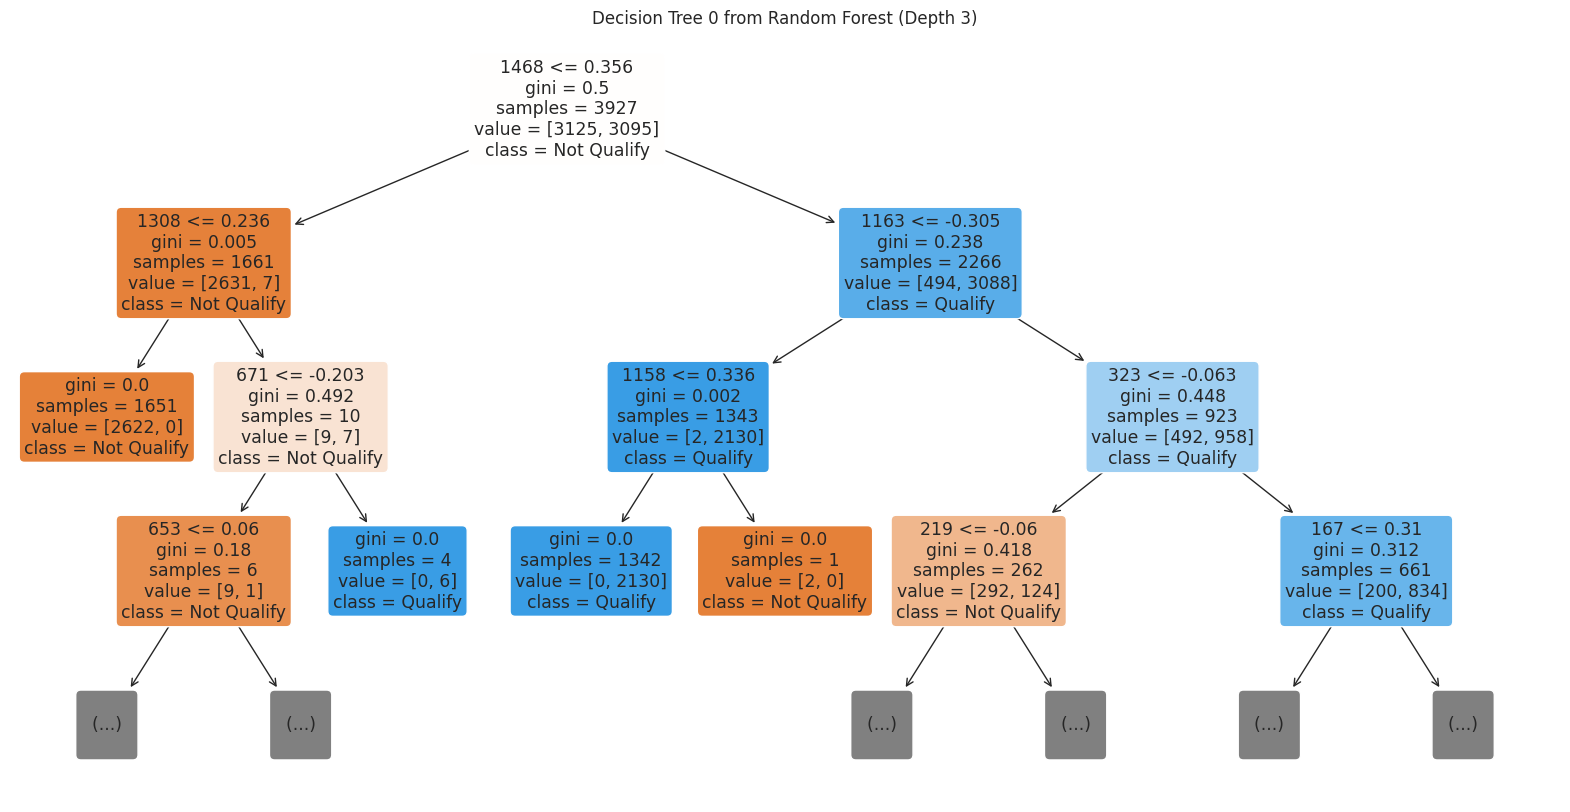

In [307]:
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt

tree_index = 0
max_depth = 3  
plt.figure(figsize=(20, 10))
plot_tree(rf_model.estimators_[tree_index], 
          feature_names=X.columns,  # Feature names for labeling
          class_names=['Not Qualify', 'Qualify'],  # Class names
          filled=True,  # Color the nodes based on class
          rounded=True,  # Round the corners of the nodes
          max_depth=max_depth)  # Limit the depth

plt.title(f'Decision Tree {tree_index} from Random Forest (Depth {max_depth})')
plt.show()


In [309]:
# Make predictions using the validation set
y_val_pred = rf_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"Validation Accuracy: {val_accuracy:.2f}")




Validation Accuracy: 0.99


In [310]:
# to see the predictions:
predictions = pd.DataFrame({'Actual': y_val, 'Predicted': y_val_pred})
print(predictions.head())

      Actual  Predicted
1692       1          1
7407       0          0
5497       0          0
700        1          1
2414       1          1


## **SVM Model**

In [320]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

In [321]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

In [323]:
# Training and Test Accuracies
train_accuracy_svm = accuracy_score(y_train, y_train_pred_svm)
test_accuracy_svm = accuracy_score(y_test, y_test_pred_svm)

In [324]:
# Bias and Variance Calculation for SVM
bias_squared_svm = np.mean((y_train - y_train_pred_svm) ** 2)
variance_svm = np.mean((y_test_pred_svm - np.mean(y_test_pred_svm)) ** 2)

In [325]:
# Results
print("SVM Model Analysis")
print(f"Training Accuracy: {train_accuracy_svm:.2f}")
print(f"Test Accuracy: {test_accuracy_svm:.2f}")
print(f"Bias (Squared): {bias_squared_svm:.2f}")
print(f"Variance: {variance_svm:.2f}")


SVM Model Analysis
Training Accuracy: 1.00
Test Accuracy: 0.99
Bias (Squared): 0.00
Variance: 0.25


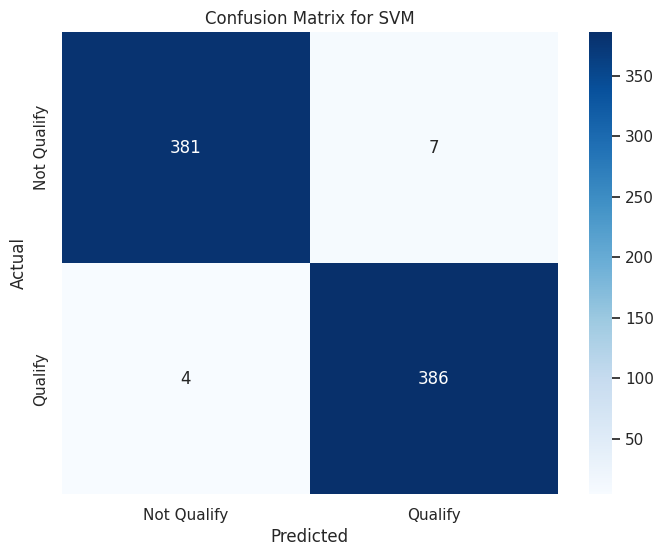

              precision    recall  f1-score   support

           0       0.99      0.98      0.99       388
           1       0.98      0.99      0.99       390

    accuracy                           0.99       778
   macro avg       0.99      0.99      0.99       778
weighted avg       0.99      0.99      0.99       778



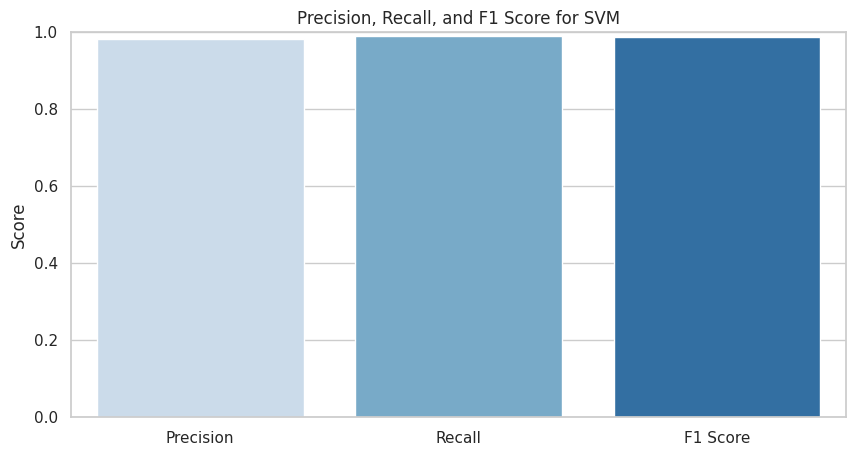

In [326]:
conf_matrix = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Qualify', 'Qualify'], yticklabels=['Not Qualify', 'Qualify'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for SVM')
plt.show()

# Step 3: Classification Report
report = classification_report(y_test, y_test_pred_svm)
print(report)

# Extracting precision, recall, and F1-score for plotting
metrics = classification_report(y_test, y_test_pred_svm, output_dict=True)
precision = metrics['1']['precision']
recall = metrics['1']['recall']
f1_score = metrics['1']['f1-score']

# Plotting Precision, Recall, and F1 Score
plt.figure(figsize=(10, 5))
metrics_names = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1_score]

sns.barplot(x=metrics_names, y=scores, palette='Blues')
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1 Score for SVM')
plt.ylabel('Score')
plt.show()


## **Bidirectional LSTM Model**

In [327]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [328]:
# Convert DataFrames to NumPy arrays
X_train_B = X_train.values
X_val_B = X_val.values
X_test_B = X_test.values

In [329]:
# Reshape the data to (samples, time_steps, features)
X_train_B = X_train_B.reshape((X_train_B.shape[0], 1, X_train_B.shape[1]))
X_val_B = X_val_B.reshape((X_val_B.shape[0], 1, X_val_B.shape[1]))
X_test_B = X_test_B.reshape((X_test_B.shape[0], 1, X_test_B.shape[1]))


In [330]:
# Initialize the BiLSTM model
model_B = Sequential()
model_B.add(Bidirectional(LSTM(64, return_sequences=False), input_shape=(X_train_B.shape[1], X_train_B.shape[2])))
model_B.add(Dense(1, activation='sigmoid'))  # Use 'softmax' for multi-class problems

In [331]:
# Compile the model
model_B.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Change loss for multi-class

In [332]:
# Train the model
history_B = model_B.fit(X_train_B, y_train, epochs=10, batch_size=32, validation_data=(X_val_B, y_val))

Epoch 1/10
195/195 [==============================] - 8s 12ms/step - loss: 0.1248 - accuracy: 0.9469 - val_loss: 0.0499 - val_accuracy: 0.9846
Epoch 2/10
195/195 [==============================] - 1s 7ms/step - loss: 0.0646 - accuracy: 0.9725 - val_loss: 0.0748 - val_accuracy: 0.9665
Epoch 3/10
195/195 [==============================] - 1s 6ms/step - loss: 0.0652 - accuracy: 0.9725 - val_loss: 0.0424 - val_accuracy: 0.9833
Epoch 4/10
195/195 [==============================] - 1s 6ms/step - loss: 0.0563 - accuracy: 0.9759 - val_loss: 0.0331 - val_accuracy: 0.9871
Epoch 5/10
195/195 [==============================] - 1s 6ms/step - loss: 0.0396 - accuracy: 0.9836 - val_loss: 0.0481 - val_accuracy: 0.9781
Epoch 6/10
195/195 [==============================] - 1s 6ms/step - loss: 0.0459 - accuracy: 0.9794 - val_loss: 0.0311 - val_accuracy: 0.9858
Epoch 7/10
195/195 [==============================] - 1s 6ms/step - loss: 0.0505 - accuracy: 0.9780 - val_loss: 0.0365 - val_accuracy: 0.9871
Epoch

In [333]:
# Evaluate the model
train_loss, train_accuracy = model_B.evaluate(X_train_B, y_train)
val_loss, val_accuracy = model_B.evaluate(X_val_B, y_val)
test_loss, test_accuracy = model_B.evaluate(X_test_B, y_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')




25/25 [==============================] - 0s 3ms/step - loss: 0.0376 - accuracy: 0.9794
Train Accuracy: 0.9897106289863586
Validation Accuracy: 0.9806950092315674
Test Accuracy: 0.9794344305992126


In [334]:
# Get predictions
y_train_pred_B = model_B.predict(X_train_B).flatten()  # Flatten to ensure it's 1D
y_val_pred_B = model_B.predict(X_val_B).flatten()
y_test_pred_B = model_B.predict(X_test_B).flatten()


25/25 [==============================] - 0s 2ms/step


In [335]:
# Calculate Bias Squared
bias_squared = np.mean((y_train - y_train_pred_B) ** 2)
variance = np.mean((y_test_pred_B - np.mean(y_test_pred_B)) ** 2)

In [336]:
# Display results
print(f'Bias Squared: {bias_squared}')
print(f'Variance: {variance}')


Bias Squared: 0.0074028528117447865
Variance: 0.23775142431259155


In [337]:
# Make predictions on the validation set
y_val_pred_B = (model_B.predict(X_val_B) > 0.5).astype("int32")  # Change threshold for multi-class
from sklearn.metrics import classification_report
print(classification_report(y_val, y_val_pred_B))

25/25 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       388
           1       1.00      0.96      0.98       389

    accuracy                           0.98       777
   macro avg       0.98      0.98      0.98       777
weighted avg       0.98      0.98      0.98       777



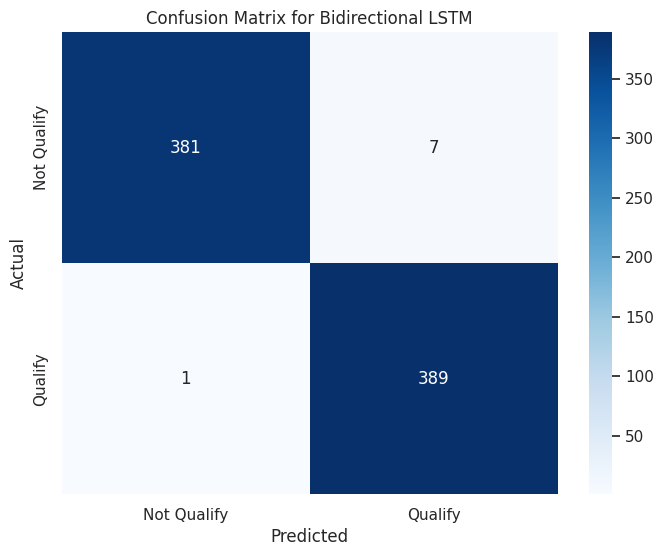

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       388
           1       0.98      1.00      0.99       390

    accuracy                           0.99       778
   macro avg       0.99      0.99      0.99       778
weighted avg       0.99      0.99      0.99       778



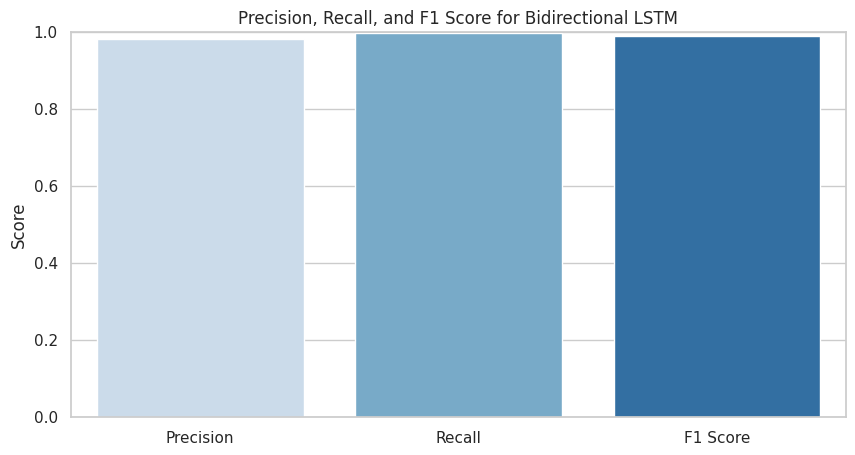

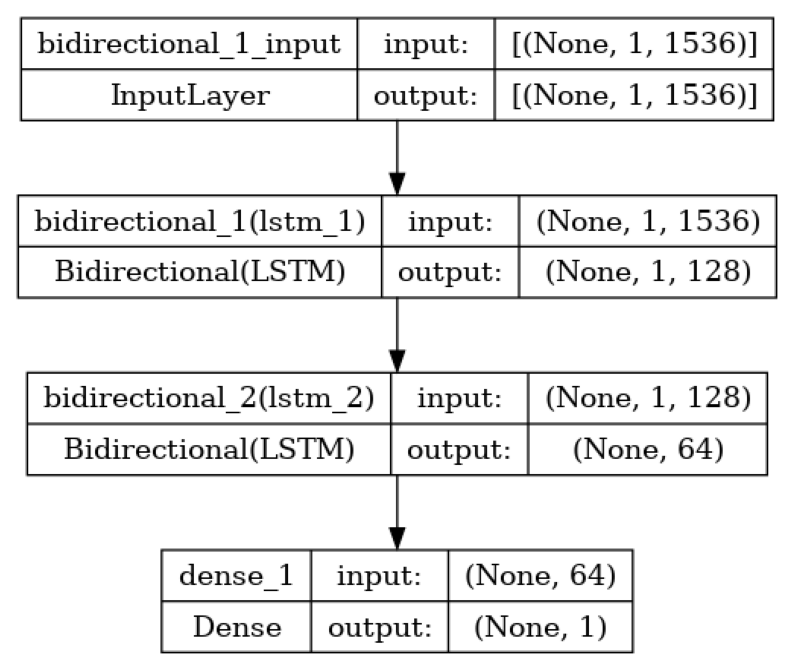

In [349]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Qualify', 'Qualify'], yticklabels=['Not Qualify', 'Qualify'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Bidirectional LSTM')
plt.show()

# Classification Report
report = classification_report(y_test, y_test_pred)
print(report)

# Extracting precision, recall, and F1-score for plotting
metrics = classification_report(y_test, y_test_pred, output_dict=True)
precision = metrics['1']['precision']
recall = metrics['1']['recall']
f1_score = metrics['1']['f1-score']

# Plotting Precision, Recall, and F1 Score
plt.figure(figsize=(10, 5))
metrics_names = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1_score]

sns.barplot(x=metrics_names, y=scores, palette='Blues')
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1 Score for Bidirectional LSTM')
plt.ylabel('Score')
plt.show()

# Plot Model Architecture
from tensorflow.keras.utils import plot_model

plot_model(model, to_file='bidirectional_lstm_model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('bidirectional_lstm_model.png'))
plt.axis('off')
plt.show()


## **MLP Model**

In [339]:
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score


In [341]:
# Build the MLP model
model_M = keras.Sequential([
    layers.Input(shape=(X_train.shape[1],)),  # Input layer: 1536 features
    layers.Dense(128, activation='relu'),      # Hidden layer 1
    layers.Dense(64, activation='relu'),       # Hidden layer 2
    layers.Dense(32, activation='relu'),       # Hidden layer 3
    layers.Dense(1, activation='sigmoid')      # Output layer for binary classification
])




In [342]:
# Compile the model
model_M.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [343]:
# Train the model
history_M = model_M.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))


Epoch 1/10
195/195 [==============================] - 3s 5ms/step - loss: 0.1208 - accuracy: 0.9514 - val_loss: 0.0612 - val_accuracy: 0.9665
Epoch 2/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0738 - accuracy: 0.9688 - val_loss: 0.0359 - val_accuracy: 0.9858
Epoch 3/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0706 - accuracy: 0.9722 - val_loss: 0.0360 - val_accuracy: 0.9858
Epoch 4/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0578 - accuracy: 0.9777 - val_loss: 0.0397 - val_accuracy: 0.9820
Epoch 5/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0527 - accuracy: 0.9781 - val_loss: 0.0293 - val_accuracy: 0.9871
Epoch 6/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0465 - accuracy: 0.9801 - val_loss: 0.0392 - val_accuracy: 0.9846
Epoch 7/10
195/195 [==============================] - 1s 4ms/step - loss: 0.0542 - accuracy: 0.9778 - val_loss: 0.0310 - val_accuracy: 0.9846
Epoch 

In [344]:
# Evaluate the model
train_loss, train_accuracy = model_M.evaluate(X_train, y_train)
val_loss, val_accuracy = model_M.evaluate(X_val, y_val)
test_loss, test_accuracy = model_M.evaluate(X_test, y_test)

print(f'Train Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {val_accuracy}')
print(f'Test Accuracy: {test_accuracy}')


25/25 [==============================] - 0s 2ms/step - loss: 0.0380 - accuracy: 0.9846
Train Accuracy: 0.9874597787857056
Validation Accuracy: 0.9871299862861633
Test Accuracy: 0.9845758080482483


In [345]:
# Make predictions on the validation set
y_val_pred = model_M.predict(X_val).flatten()  # Flatten to get 1D array

# Convert predictions to binary labels
y_val_pred_labels = (y_val_pred > 0.5).astype(int)

# Calculate bias squared
bias_squared = np.mean((y_val - y_val_pred_labels) ** 2)

# Calculate variance
variance = np.mean((y_val_pred_labels - np.mean(y_val_pred_labels)) ** 2)

print(f'Bias Squared: {bias_squared}')
print(f'Variance: {variance}')


25/25 [==============================] - 0s 2ms/step
Bias Squared: 0.01287001287001287
Variance: 0.2499300182697866


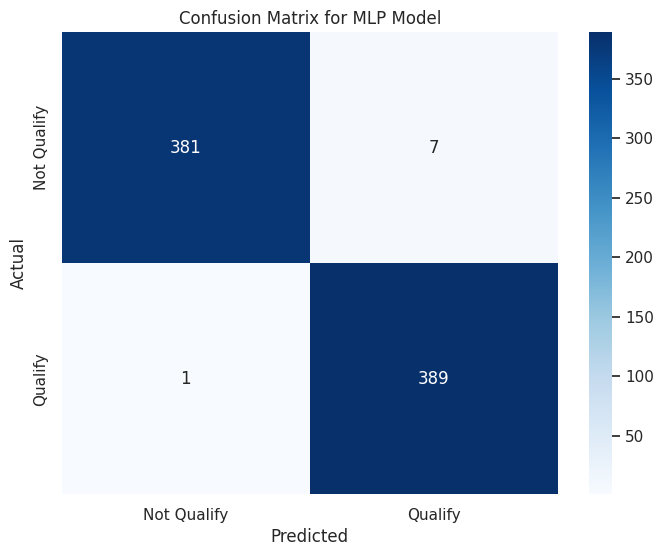

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       388
           1       0.98      1.00      0.99       390

    accuracy                           0.99       778
   macro avg       0.99      0.99      0.99       778
weighted avg       0.99      0.99      0.99       778



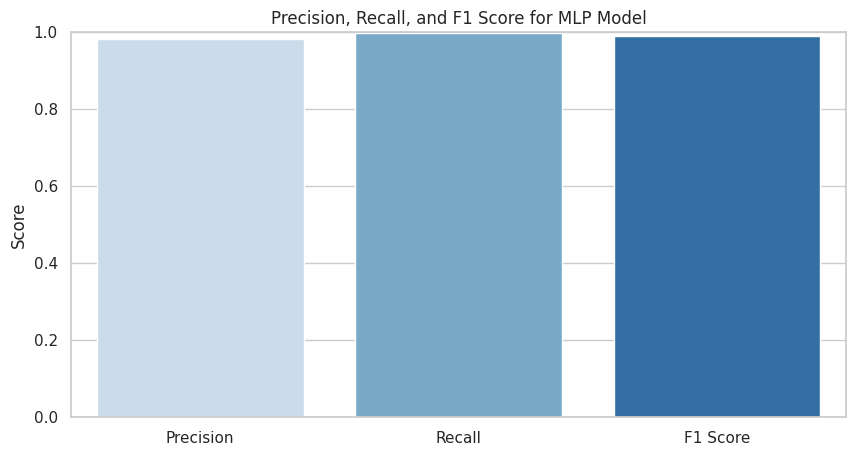

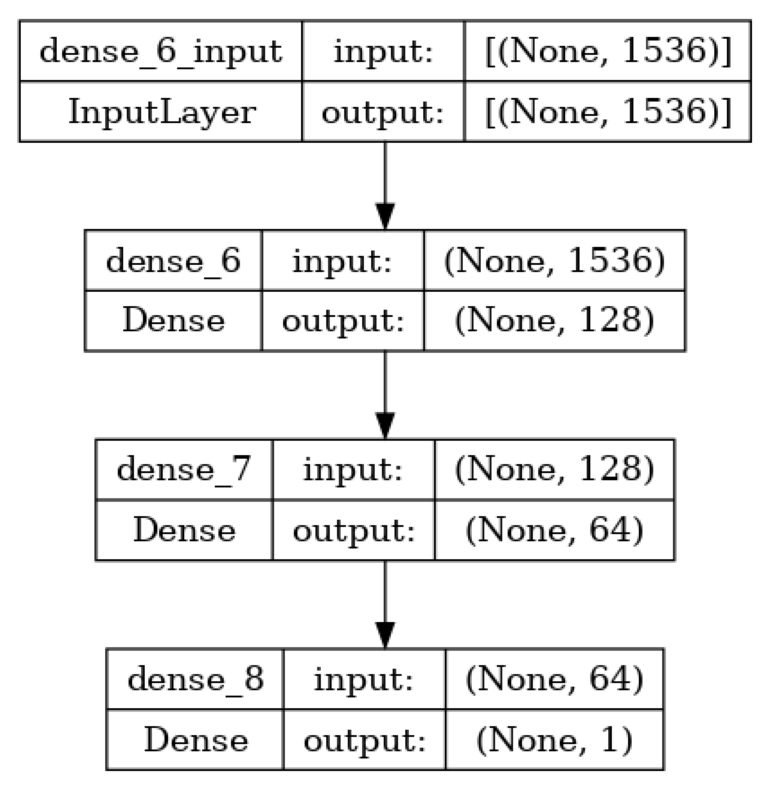

In [350]:
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense



# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Qualify', 'Qualify'], yticklabels=['Not Qualify', 'Qualify'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for MLP Model')
plt.show()

# Classification Report
report = classification_report(y_test, y_test_pred)
print(report)

# Extracting precision, recall, and F1-score for plotting
metrics = classification_report(y_test, y_test_pred, output_dict=True)
precision = metrics['1']['precision']
recall = metrics['1']['recall']
f1_score = metrics['1']['f1-score']

# Plotting Precision, Recall, and F1 Score
plt.figure(figsize=(10, 5))
metrics_names = ['Precision', 'Recall', 'F1 Score']
scores = [precision, recall, f1_score]

sns.barplot(x=metrics_names, y=scores, palette='Blues')
plt.ylim(0, 1)
plt.title('Precision, Recall, and F1 Score for MLP Model')
plt.ylabel('Score')
plt.show()

# Step 6: Plot Model Architecture (Optional)
from tensorflow.keras.utils import plot_model

plot_model(model_M, to_file='mlp_model.png', show_shapes=True, show_layer_names=True)
plt.figure(figsize=(10, 10))
plt.imshow(plt.imread('mlp_model.png'))
plt.axis('off')
plt.show()


## **Explainable AI**

In [356]:
import shap

In [359]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [360]:
# Create a SHAP explainer
explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_train)



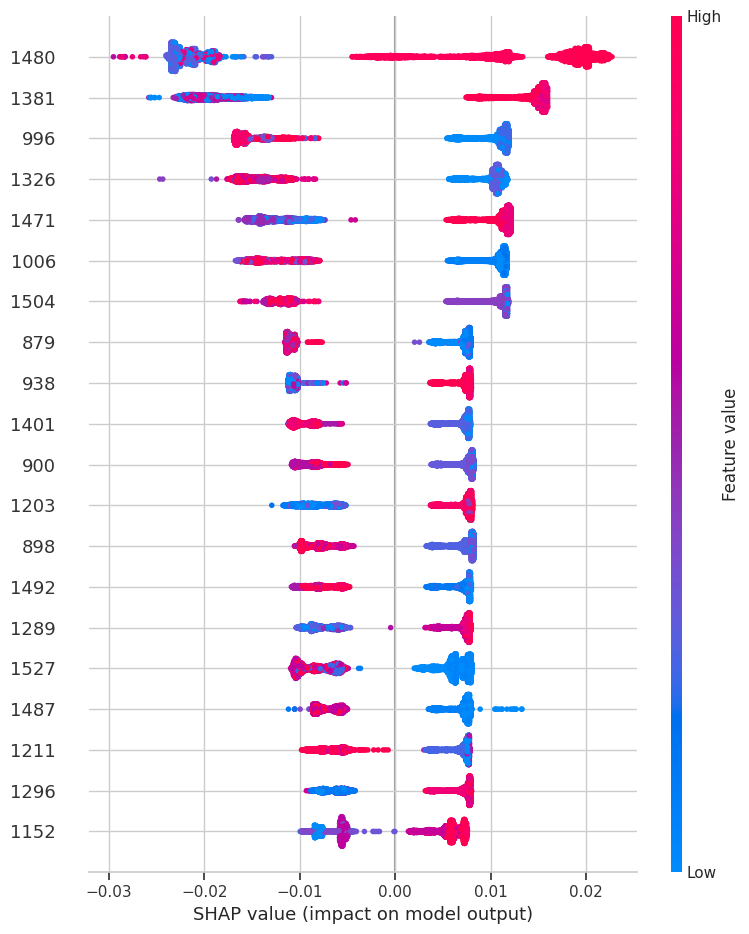

In [361]:
shap.summary_plot(shap_values[1], X_train)  # For the 'qualify' class


In [ ]:
X_train_np = X_train.to_numpy() if isinstance(X_train, pd.DataFrame) else X_train

In [ ]:
# Create the LIME explainer
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_np,
    feature_names=[str(i) for i in range(X_train_np.shape[1])],  # Assuming features are named as numbers
    class_names=['Not Qualify', 'Qualify'],
    mode='classification'
)


In [367]:
# Choose an instance to explain 
instance_to_explain = X_test.iloc[0].values.reshape(1, -1)  

# Generate the explanation
explanation = explainer.explain_instance(
    data_row=instance_to_explain[0],
    predict_fn=rf_model.predict_proba
)
# Visualize the explanation
explanation.show_in_notebook()

In [368]:
# Import necessary libraries
from keras.models import save_model

# Save Keras models
model_M.save('model_M.h5')
model_B.save('model_B.h5')

# For non-Keras models (like SVM, Logistic Regression, Random Forest), use pickle
import pickle

# Save non-Keras models using pickle
with open('svm_model.pkl', 'wb') as f:
    pickle.dump(svm_model, f)

with open('log_reg_model.pkl', 'wb') as f:
    pickle.dump(log_reg_model, f)

with open('rf_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)


In [ ]:
# Import necessary libraries
from keras.models import load_model
import pickle

# Load Keras models
model_B = load_model('/kaggle/input/models/model_B.h5')
model_M = load_model('/kaggle/input/models/model_M.h5')

In [ ]:
# Load non-Keras models using pickle
with open('/kaggle/input/models/svm_model.pkl', 'rb') as f:
    svm_model = pickle.load(f)

with open('/kaggle/input/models/log_reg_model.pkl', 'rb') as f:
    log_reg_model = pickle.load(f)

with open('/kaggle/input/models/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)


